<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Sentiment Analysis Model (Problem 1)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [ ]:
# Import the Required Packages
from tensorflow import keras
print('keras: ', keras.__version__)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

keras:  2.4.0


### GitHub + Colab

In [ ]:
#run for GitHub Colab
!git clone "https://github.com/OldManSteve/DL_Assg2.git"


Cloning into 'DL_Assg2'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 51 (delta 15), reused 42 (delta 9), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [ ]:
#GitHub Colab directory
# Directories for files
map_file = '/content/DL_Assg2/mapping.csv'
dataset_file = '/content/DL_Assg2/dataset.csv'

In [ ]:
#Google drive model upload/save storage
from google.colab import drive
drive.mount('/content/drive')

model_path='/content/drive/My Drive/Colab Notebooks/DL_Assg2_Models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [ ]:
# Load the emoji_dictionary
import pandas as pd
df = pd.read_csv(map_file, delimiter=',')
emoji_dictionary = df.loc[:,'emoticons'].to_dict()
print(emoji_dictionary)
print('A total of: ', len(emoji_dictionary), 'Emoji Icons')

{0: '😍', 1: '😂', 2: '📷', 3: '🔥', 4: '❤'}
A total of:  5 Emoji Icons


In [ ]:
# load the dataset
dat = pd.read_csv(dataset_file, delimiter=',')
texts = dat.loc[:,'TEXT'].values 
labels = dat.loc[:,'Label'].values

dat.head()

,TEXT,Label
0,Been friends since 7th grade. Look at us now w...,0
1,This is what it looks like when someone loves ...,1
2,RT @user this white family was invited to a Bl...,1
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2
4,Maxwell heads home @ Summa Akron City Hospital\n,0


In [ ]:
# Check the maximum length of texts
max_len = -1
for example in texts:
    if len(example.split()) > max_len:
        max_len = len(example.split())
        
print('the maximum length of the text inputs is ', max_len)

the maximum length of the text inputs is  34


### 1.2 Data Processing


In [ ]:
# Convert the texts and labels into numeric tensors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # We will only consider the top 10,000 words (vocabulary) in the dataset (dictionary)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

def vectorize_sequences(sequences, dimension=5):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

X = pad_sequences(sequences, maxlen=max_len)
y = vectorize_sequences(labels)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Found 54076 unique tokens.
Shape of data tensor: (42546, 34)
Shape of label tensor: (42546, 5)


### 1.3 Data Sampling

In [ ]:
# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)
# Refer the report Appendix
# Please enter the random_state assigned to your group

## Step 2 – Develop a Sentiment Analysis Model [CONV1D]

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

### Model #1 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 8)             80000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 32)            1312      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 32)             5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 86,629
Trainable params: 86,629
Non-trainable params: 0
__________________________________________________

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=2,
                    validation_split=0.2)

Epoch 1/10
13614/13614 [==============================] - 74s 5ms/step - loss: 1.3423 - acc: 0.4240 - val_loss: 1.2105 - val_acc: 0.4611
Epoch 2/10
13614/13614 [==============================] - 76s 6ms/step - loss: 1.1959 - acc: 0.4754 - val_loss: 1.1729 - val_acc: 0.4931
Epoch 3/10
13614/13614 [==============================] - 74s 5ms/step - loss: 1.1523 - acc: 0.5006 - val_loss: 1.1426 - val_acc: 0.5126
Epoch 4/10
13614/13614 [==============================] - 74s 5ms/step - loss: 1.1208 - acc: 0.5150 - val_loss: 1.1229 - val_acc: 0.5120
Epoch 5/10
13614/13614 [==============================] - 74s 5ms/step - loss: 1.0991 - acc: 0.5324 - val_loss: 1.1114 - val_acc: 0.5272
Epoch 6/10
13614/13614 [==============================] - 75s 6ms/step - loss: 1.0836 - acc: 0.5420 - val_loss: 1.0950 - val_acc: 0.5422
Epoch 7/10
13614/13614 [==============================] - 75s 6ms/step - loss: 1.0694 - acc: 0.5509 - val_loss: 1.0976 - val_acc: 0.5476
Epoch 8/10
13614/13614 [=================

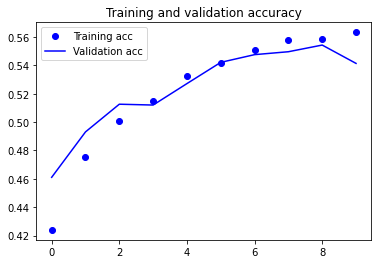

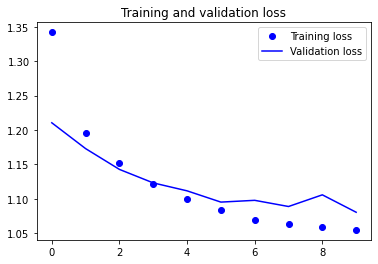

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_1.h5')
model.save('text_model_conv1d_1.h5')

### Model #1_1 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 8)             80000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 32)            1312      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 32)             5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 86,629
Trainable params: 86,629
Non-trainable params: 0
__________________________________________________

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=2,
                    validation_split=0.2)

Epoch 1/20
13614/13614 [==============================] - 74s 5ms/step - loss: 1.3145 - acc: 0.4295 - val_loss: 1.2081 - val_acc: 0.4736
Epoch 2/20
13614/13614 [==============================] - 76s 6ms/step - loss: 1.1941 - acc: 0.4757 - val_loss: 1.1715 - val_acc: 0.4953
Epoch 3/20
13614/13614 [==============================] - 73s 5ms/step - loss: 1.1551 - acc: 0.4976 - val_loss: 1.1473 - val_acc: 0.5082
Epoch 4/20
13614/13614 [==============================] - 73s 5ms/step - loss: 1.1288 - acc: 0.5079 - val_loss: 1.1322 - val_acc: 0.5188
Epoch 5/20
13614/13614 [==============================] - 72s 5ms/step - loss: 1.1084 - acc: 0.5237 - val_loss: 1.1139 - val_acc: 0.5206
Epoch 6/20
13614/13614 [==============================] - 74s 5ms/step - loss: 1.0846 - acc: 0.5364 - val_loss: 1.0898 - val_acc: 0.5383
Epoch 7/20
13614/13614 [==============================] - 73s 5ms/step - loss: 1.0619 - acc: 0.5486 - val_loss: 1.0765 - val_acc: 0.5489
Epoch 8/20
13614/13614 [=================

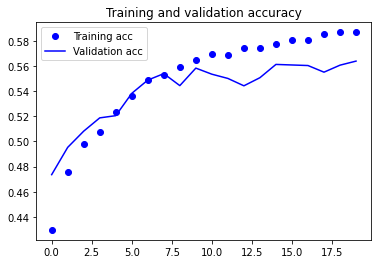

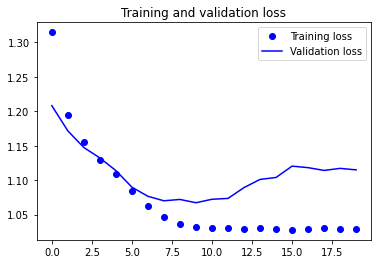

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_1_1.h5')
model.save('text_model_conv1d_1_1.h5')

### Model #2 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(1024, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(1024, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 34, 8)             80000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 1024)          41984     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 1024)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 1024)           5243904   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 5,371,013
Trainable params: 5,371,013
Non-trainable params: 0
____________________________________________

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=2,
                    validation_split=0.2)

Epoch 1/10
13614/13614 [==============================] - 205s 15ms/step - loss: 1.2183 - acc: 0.4620 - val_loss: 1.1717 - val_acc: 0.4890
Epoch 2/10
13614/13614 [==============================] - 206s 15ms/step - loss: 1.1379 - acc: 0.5143 - val_loss: 1.1459 - val_acc: 0.5300
Epoch 3/10
13614/13614 [==============================] - 219s 16ms/step - loss: 1.1159 - acc: 0.5296 - val_loss: 1.1381 - val_acc: 0.5225
Epoch 4/10
13614/13614 [==============================] - 210s 15ms/step - loss: 1.1127 - acc: 0.5415 - val_loss: 1.1264 - val_acc: 0.5360
Epoch 5/10
13614/13614 [==============================] - 205s 15ms/step - loss: 1.1021 - acc: 0.5523 - val_loss: 1.2849 - val_acc: 0.5499
Epoch 6/10
13614/13614 [==============================] - 206s 15ms/step - loss: 1.1086 - acc: 0.5591 - val_loss: 1.1661 - val_acc: 0.5552
Epoch 7/10
13614/13614 [==============================] - 218s 16ms/step - loss: 1.1029 - acc: 0.5645 - val_loss: 1.2197 - val_acc: 0.5015
Epoch 8/10
13614/13614 [===

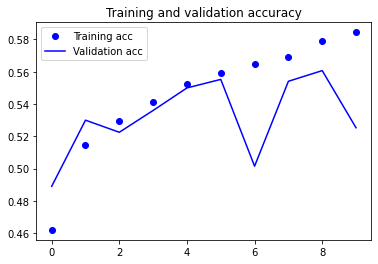

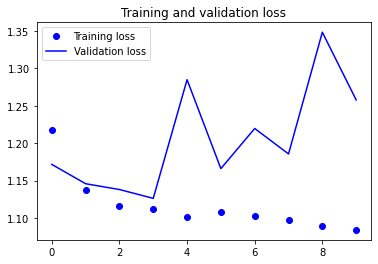

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_2.h5')
model.save('text_model_conv1d_2.h5')

### Model #3 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 8)             80000     
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            1312      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 32)             5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 86,629
Trainable params: 86,629
Non-trainable params: 0
____________________________________________________

In [ ]:
# Train the Model

model.compile(optimizer=Adam(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
213/213 [==============================] - 2s 8ms/step - loss: 1.4440 - acc: 0.4163 - val_loss: 1.3330 - val_acc: 0.4311
Epoch 2/10
213/213 [==============================] - 1s 7ms/step - loss: 1.2038 - acc: 0.4752 - val_loss: 1.1392 - val_acc: 0.5209
Epoch 3/10
213/213 [==============================] - 1s 7ms/step - loss: 1.0812 - acc: 0.5451 - val_loss: 1.0908 - val_acc: 0.5350
Epoch 4/10
213/213 [==============================] - 2s 7ms/step - loss: 0.9944 - acc: 0.5724 - val_loss: 1.0705 - val_acc: 0.5413
Epoch 5/10
213/213 [==============================] - 2s 7ms/step - loss: 0.9235 - acc: 0.6147 - val_loss: 1.0680 - val_acc: 0.5649
Epoch 6/10
213/213 [==============================] - 2s 7ms/step - loss: 0.8563 - acc: 0.6573 - val_loss: 1.0676 - val_acc: 0.5758
Epoch 7/10
213/213 [==============================] - 2s 7ms/step - loss: 0.7920 - acc: 0.6858 - val_loss: 1.0836 - val_acc: 0.5824
Epoch 8/10
213/213 [==============================] - 2s 7ms/step - loss: 0.

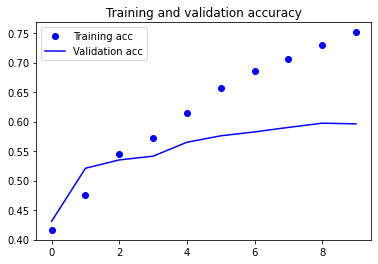

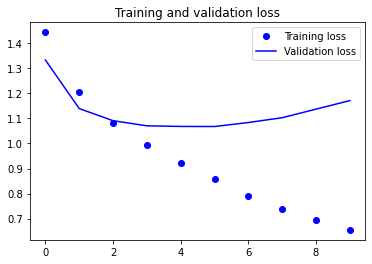

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_3.h5')
model.save('text_model_conv1d_3.h5')

### Model #3_1 (not saved)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 34, 8)             80000     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 30, 32)            1312      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 2, 32)             5152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)              

In [ ]:
# Train the Model

model.compile(optimizer=Adam(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
213/213 [==============================] - 2s 8ms/step - loss: 1.4673 - acc: 0.4185 - val_loss: 1.3713 - val_acc: 0.4311
Epoch 2/30
213/213 [==============================] - 2s 7ms/step - loss: 1.2357 - acc: 0.4672 - val_loss: 1.1951 - val_acc: 0.5104
Epoch 3/30
213/213 [==============================] - 2s 7ms/step - loss: 1.1397 - acc: 0.5306 - val_loss: 1.1574 - val_acc: 0.5269
Epoch 4/30
213/213 [==============================] - 2s 7ms/step - loss: 1.0760 - acc: 0.5523 - val_loss: 1.1342 - val_acc: 0.5298
Epoch 5/30
213/213 [==============================] - 2s 7ms/step - loss: 1.0266 - acc: 0.5711 - val_loss: 1.1214 - val_acc: 0.5345
Epoch 6/30
213/213 [==============================] - 2s 8ms/step - loss: 0.9846 - acc: 0.5962 - val_loss: 1.1113 - val_acc: 0.5416
Epoch 7/30
213/213 [==============================] - 2s 8ms/step - loss: 0.9457 - acc: 0.6277 - val_loss: 1.0999 - val_acc: 0.5595
Epoch 8/30
213/213 [==============================] - 2s 7ms/step - loss: 0.

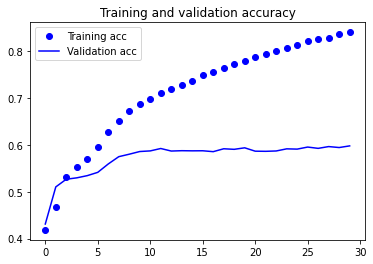

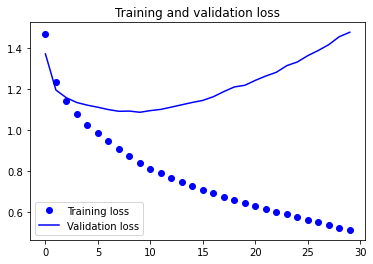

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_3_1.h5')
model.save('text_model_conv1d_3_1.h5')

### Model #3_1

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 34, 8)             80000     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 30, 32)            1312      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2, 32)             5152      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 32)              

In [ ]:
# Train the Model

model.compile(optimizer=Adam(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/15
213/213 [==============================] - 2s 8ms/step - loss: 1.4811 - acc: 0.4158 - val_loss: 1.3984 - val_acc: 0.4311
Epoch 2/15
213/213 [==============================] - 2s 7ms/step - loss: 1.2505 - acc: 0.4579 - val_loss: 1.1983 - val_acc: 0.4987
Epoch 3/15
213/213 [==============================] - 2s 7ms/step - loss: 1.1358 - acc: 0.5219 - val_loss: 1.1609 - val_acc: 0.5169
Epoch 4/15
213/213 [==============================] - 2s 7ms/step - loss: 1.0789 - acc: 0.5492 - val_loss: 1.1404 - val_acc: 0.5297
Epoch 5/15
213/213 [==============================] - 2s 7ms/step - loss: 1.0308 - acc: 0.5750 - val_loss: 1.1313 - val_acc: 0.5372
Epoch 6/15
213/213 [==============================] - 2s 7ms/step - loss: 0.9965 - acc: 0.5957 - val_loss: 1.1284 - val_acc: 0.5329
Epoch 7/15
213/213 [==============================] - 2s 7ms/step - loss: 0.9637 - acc: 0.6115 - val_loss: 1.1272 - val_acc: 0.5426
Epoch 8/15
213/213 [==============================] - 2s 7ms/step - loss: 0.

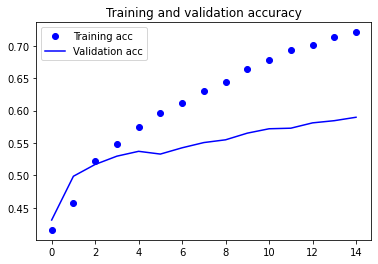

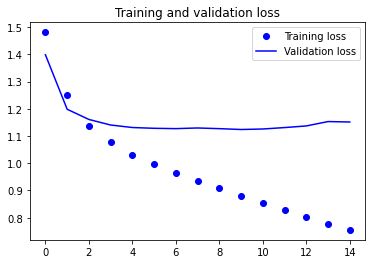

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_3_1.h5')
model.save('text_model_conv1d_3_1.h5')

### Model #3_2 (not saved)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.Conv1D(1024, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(1024, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 34, 8)             80000     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 30, 1024)          41984     
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 1024)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 1024)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 1024)           5243904   
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 1024)           0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 1024)            

In [ ]:
# Train the Model

model.compile(optimizer=Adam(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
213/213 [==============================] - 7s 34ms/step - loss: 1.3953 - acc: 0.4515 - val_loss: 1.2167 - val_acc: 0.5068
Epoch 2/30
213/213 [==============================] - 7s 33ms/step - loss: 1.1327 - acc: 0.5263 - val_loss: 1.1502 - val_acc: 0.5273
Epoch 3/30
213/213 [==============================] - 7s 33ms/step - loss: 1.0470 - acc: 0.5591 - val_loss: 1.1317 - val_acc: 0.5263
Epoch 4/30
213/213 [==============================] - 7s 32ms/step - loss: 0.9929 - acc: 0.5869 - val_loss: 1.1346 - val_acc: 0.5366
Epoch 5/30
213/213 [==============================] - 7s 33ms/step - loss: 0.9480 - acc: 0.6198 - val_loss: 1.1150 - val_acc: 0.5585
Epoch 6/30
213/213 [==============================] - 7s 33ms/step - loss: 0.8940 - acc: 0.6580 - val_loss: 1.1011 - val_acc: 0.5742
Epoch 7/30
213/213 [==============================] - 7s 33ms/step - loss: 0.8433 - acc: 0.6857 - val_loss: 1.0956 - val_acc: 0.5823
Epoch 8/30
213/213 [==============================] - 7s 33ms/step - 

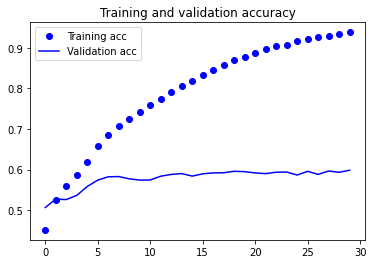

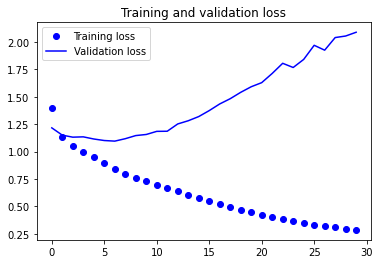

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_conv1d_3_2.h5')
model.save('text_model_conv1d_3_2.h5')

## Step 2 – Develop a Sentiment Analysis Model [GRU]

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

### Model #1 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(32))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 8)             80000     
_________________________________________________________________
gru_2 (GRU)                  (None, 34, 32)            4032      
_________________________________________________________________
gru_3 (GRU)                  (None, 34, 32)            6336      
_________________________________________________________________
gru_4 (GRU)                  (None, 34, 32)            6336      
_________________________________________________________________
gru_5 (GRU)                  (None, 34, 32)            6336      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten (Flatten)            (None, 32)               

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
213/213 [==============================] - 99s 465ms/step - loss: 1.4436 - acc: 0.4225 - val_loss: 1.4224 - val_acc: 0.4311
Epoch 2/10
213/213 [==============================] - 97s 455ms/step - loss: 1.4267 - acc: 0.4225 - val_loss: 1.4174 - val_acc: 0.4311
Epoch 3/10
213/213 [==============================] - 98s 458ms/step - loss: 1.4147 - acc: 0.4225 - val_loss: 1.3912 - val_acc: 0.4311
Epoch 4/10
213/213 [==============================] - 98s 459ms/step - loss: 1.3376 - acc: 0.4382 - val_loss: 1.2764 - val_acc: 0.4580
Epoch 5/10
213/213 [==============================] - 98s 459ms/step - loss: 1.2416 - acc: 0.4774 - val_loss: 1.2123 - val_acc: 0.4956
Epoch 6/10
213/213 [==============================] - 97s 456ms/step - loss: 1.1929 - acc: 0.4988 - val_loss: 1.1775 - val_acc: 0.5072
Epoch 7/10
213/213 [==============================] - 97s 457ms/step - loss: 1.1567 - acc: 0.5128 - val_loss: 1.1519 - val_acc: 0.5113
Epoch 8/10
213/213 [==============================] - 9

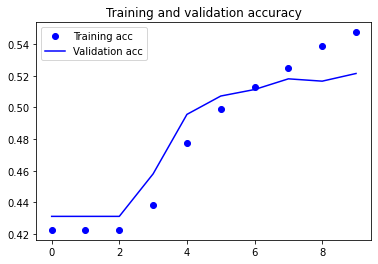

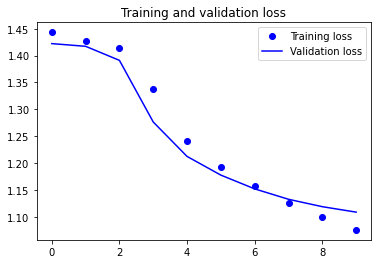

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_gru_1.h5')
model.save('text_model_gru_1.h5')

### Model #2 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.GRU(512, return_sequences=True))
model.add(layers.GRU(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.GRU(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(128))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 8)             80000     
_________________________________________________________________
gru_7 (GRU)                  (None, 34, 512)           801792    
_________________________________________________________________
gru_8 (GRU)                  (None, 34, 512)           1575936   
_________________________________________________________________
gru_9 (GRU)                  (None, 34, 256)           591360    
_________________________________________________________________
gru_10 (GRU)                 (None, 34, 256)           394752    
_________________________________________________________________
gru_11 (GRU)                 (None, 128)               148224    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
213/213 [==============================] - 114s 537ms/step - loss: 1.4308 - acc: 0.4216 - val_loss: 1.3955 - val_acc: 0.4311
Epoch 2/10
213/213 [==============================] - 112s 526ms/step - loss: 1.3231 - acc: 0.4440 - val_loss: 1.2673 - val_acc: 0.4668
Epoch 3/10
213/213 [==============================] - 112s 525ms/step - loss: 1.2308 - acc: 0.4726 - val_loss: 1.1941 - val_acc: 0.4894
Epoch 4/10
213/213 [==============================] - 113s 529ms/step - loss: 1.1665 - acc: 0.5001 - val_loss: 1.1575 - val_acc: 0.4996
Epoch 5/10
213/213 [==============================] - 112s 526ms/step - loss: 1.1184 - acc: 0.5178 - val_loss: 1.1250 - val_acc: 0.5106
Epoch 6/10
213/213 [==============================] - 113s 531ms/step - loss: 1.0831 - acc: 0.5369 - val_loss: 1.1073 - val_acc: 0.5236
Epoch 7/10
213/213 [==============================] - 112s 525ms/step - loss: 1.0547 - acc: 0.5481 - val_loss: 1.1045 - val_acc: 0.5178
Epoch 8/10
213/213 [============================

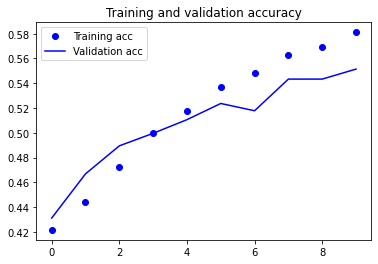

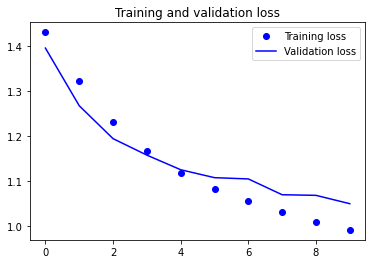

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_gru_2.h5')
model.save('text_model_gru_2.h5')

### Model #3 (Replicate as necessary for other models)

In [ ]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, 8, input_length=max_len))
model.add(layers.GRU(512, return_sequences=True))
model.add(layers.GRU(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.GRU(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(layers.GRU(128))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 34, 8)             80000     
_________________________________________________________________
gru (GRU)                    (None, 34, 512)           801792    
_________________________________________________________________
gru_1 (GRU)                  (None, 34, 512)           1575936   
_________________________________________________________________
gru_2 (GRU)                  (None, 34, 256)           591360    
_________________________________________________________________
gru_3 (GRU)                  (None, 34, 256)           394752    
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               148224    
_________________________________________________________________
flatten (Flatten)            (None, 128)             

In [ ]:
# Train the Model

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/20
213/213 [==============================] - 96s 452ms/step - loss: 1.4093 - acc: 0.4230 - val_loss: 1.3255 - val_acc: 0.4440
Epoch 2/20
213/213 [==============================] - 95s 446ms/step - loss: 1.2896 - acc: 0.4550 - val_loss: 1.2315 - val_acc: 0.4768
Epoch 3/20
213/213 [==============================] - 95s 445ms/step - loss: 1.2053 - acc: 0.4860 - val_loss: 1.2175 - val_acc: 0.4890
Epoch 4/20
213/213 [==============================] - 94s 443ms/step - loss: 1.1460 - acc: 0.5072 - val_loss: 1.1709 - val_acc: 0.4997
Epoch 5/20
213/213 [==============================] - 95s 447ms/step - loss: 1.1054 - acc: 0.5273 - val_loss: 1.1308 - val_acc: 0.5104
Epoch 6/20
213/213 [==============================] - 94s 442ms/step - loss: 1.0738 - acc: 0.5398 - val_loss: 1.1054 - val_acc: 0.5173
Epoch 7/20
213/213 [==============================] - 95s 444ms/step - loss: 1.0500 - acc: 0.5500 - val_loss: 1.0848 - val_acc: 0.5347
Epoch 8/20
213/213 [==============================] - 9

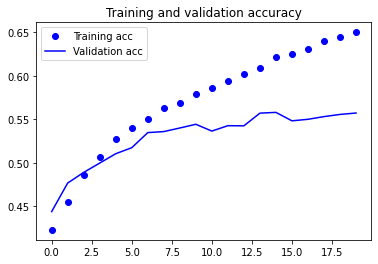

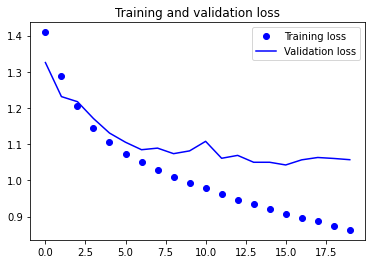

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save(model_path+'text_model_gru_3.h5')
model.save('text_model_gru_3.h5')

## Step 3 – Evaluate the Model using Testing Data 

In [ ]:
# Model #1 (replicate where necessary for other models)
from tensorflow.keras import models
#model.load_weights('text_model_1.h5')

model = models.load_model(model_path+'text_model_conv1d_3_1.h5')

In [ ]:
# Save the Best Model
model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction

In [ ]:
model.load_weights('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input()])

western


In [ ]:
# convert the user input into numeric tensor
import pandas as pd
def prediction(model, text_array, items_list):
    prob = model.predict(data)
    pro_df = pd.DataFrame(prob, columns = items_list)
    result = items_list[np.argmax(prob)]
    return pro_df, result

sequences = tokenizer.texts_to_sequences(text_input)
data = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# show the model output using predict function
prediction(model, data, emoji_dictionary)

(          0         1         2         3         4
 0  0.275362  0.243967  0.180515  0.143275  0.156882, '😍')